# Object Detection - YOLO Lab using PowerAI

The goal of the notebook is to introduce a few key concepts around YOLO, and show how you can use Keras and Tensorflow which are part of the PowerAI distribution to solve these types of problems.

Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242). 

**You will learn to**:
- Use object detection to 
    - draw bounding boxes on images
    - count object instances
- Create a video with bounding boxes
- [Optional - Work In Progress]: Training a network using a new dataset


### Applications of Object Detection ....

<img src="nb_images/applications.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Applications for Object Detection with YOLO**<br> </center></caption>



### Definitions :
- PowerAI - IBM Deeplearning Frameworks optimized on IBM Power Systems leveraging Nvidia GPUs
- YOLO   -  object detection algorithm using state of the art deep learning technique
- COCO Dataset - a standard object detection dataset hosting > 100K labelled images
- Tensor - An N dimensional array  
- Training - Phase of machine/deep learning where you are adjusting model weights to predict known outputs.
- Inference - Phase of machine/deep learning where you are using a previously trained model to predict output with new data
- Anchor Boxes - Technique used in object detection algorithms to allow detection of more than one object in a grid cell

- non max suppression - Technique used is object detection algorithm to prune away low probability predicted boxes.
- batch norm - Technique use in deep learning to allow for faster training.
- leaky relu - Non linear activation function that is used in many image classification / detection algorithms.




In [14]:
# Run the following cell to load the packages and dependencies and lets get started!
import argparse as ap
import os
import numpy as np
import cv2
import sys
import re
import json
import shutil

import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model, model_from_json
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.python import debug as tf_debug


from yolo_utils import read_classes, read_anchors
import random
import colorsys
from IPython.display import Image


# Load library functions
Most of the code for this lab is provided via the `yolo_demo` convenience library.  This code is available on github at 
- https://github.com/dustinvanstee/mldl-101/tree/master/lab4-yolo-keras

In [15]:
# import all the helper functions that we will use for this lab
from yolo_demo import *

**Important Note**: As you can see, we import Keras's backend as K. This means that to use a Keras function in this notebook, you will need to write: `K.function(...)`.

# Lab explanation

Here we use a Keras implementation built by Allan Zelener called Yad2k .  This initial implementation has been significantly modified for this lab. 

**Under the hood, we will leverage PowerAI Keras/Tensorflow libraries**

Below we will load our demo environment.  

The general flow of this lab will be to expose some high level functions to see how the algorith works in general, but the complexity of the code will be encapsulated in the yolo_demo.py .  All this code is accessible at 
https://github.com/dustinvanstee/mldl-101/tree/master/lab4-yolo-keras

This lab will make use of a pre-trained yolo model that was built using the COCO dataset.  *This lab will not implement retraining this network based on newly labelled images and classes.*



# Load Session 

This lab will make use of both Keras and Tensorflow.  Keras is used for the high level implementation of the neural network, and tensorflow is used as the deep learning "backend".  Note, in many cases it is ok to mix tensorflow and keras code, but in general, for portability use Keras as much as possible.

Here we load a new tensorflow session via K.get_session() and setup the yolo_demo configuration files.  

The configurations files define the 80 coco classes, and the anchor box coordinates used for this demo.
- Note : anchor boxes are used when there are multiple objects in the same grid location.

The mydemo object has all the built in functions we will need.  Lets explore what we can do  ....

In [16]:
sess = K.get_session()

# TF Debugger... try standard!
#from tensorflow.python import debug as tf_debug
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

mydemo = yolo_demo(sess,batch_size=1) 
mydemo.vi_mode("image")
mydemo.class_names(read_classes("./model_data/coco_classes.txt"))
mydemo.anchors(read_anchors("./model_data/yolo_anchors.txt"))




# View Classes in the COCO dataset
Here we are using a model that was pre-trained on the MS COCO dataset 
http://cocodataset.org/#home

Lets take a look at the 80 classes we can detect by default

In [5]:
print(str(mydemo.class_names()))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Load Image into Demo

For this lab, lets start with an image pre-downloaded from the web just to experiment.  We will try to identify all the elephants and giraphes in this image.  
** note : this a much more difficult task than basic image classification **

set_image_shape : Setting self.image_shape to (701, 1024, 3)


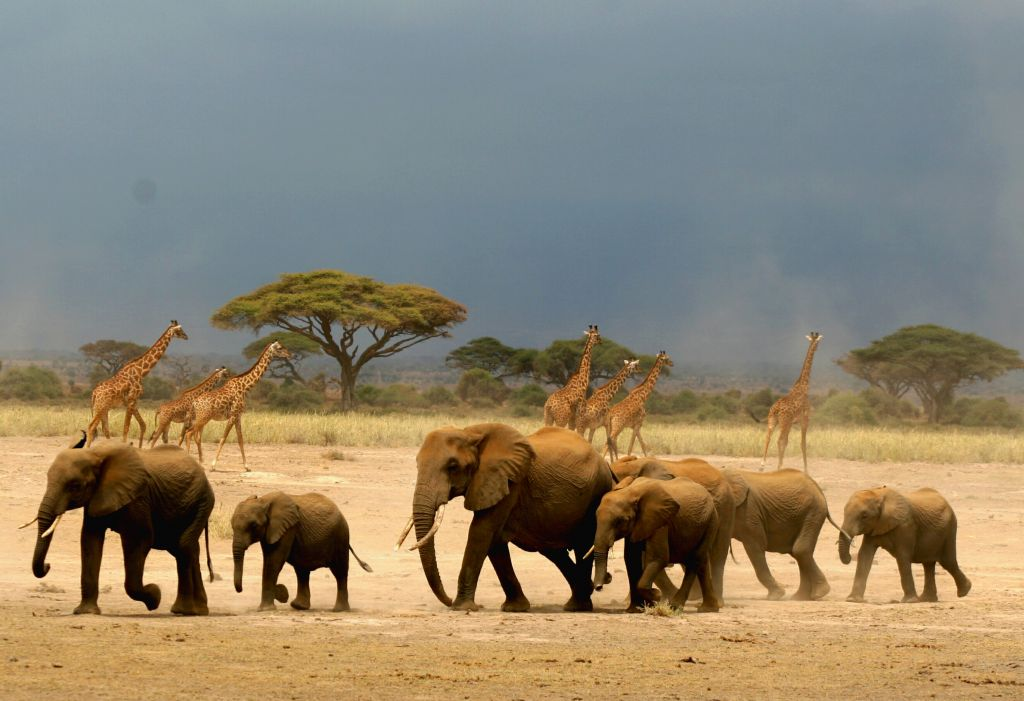

In [17]:
mydemo.input_vi("./images/safari2.jpg")
mydemo.set_image_shape()
mydemo.infer_mode("darknet")
Image("images/safari2.jpg")
# note the number of elephants and giraphes for later... (7, 7)

### Download the Pre-trained Model
Here we make use of a model that was built using the Coco dataset.  The h5 file is a standard format for DL models.

HDF5 file will typically contain:

* the architecture of the model, allowing to re-create the model
* the weights of the model
* the training configuration (loss, optimizer)
* the state of the optimizer, allowing to resume training exactly where you left off.

In [7]:
system = !uname -m
system = str(system[0])
print("System type = {}".format(system))
if(system == 'x86_64' and not os.path.exists('./model_data/yolo.h5')) :
    print("bypassing download")
elif(system == 'ppc64le' and not os.path.exists('./model_data/yolo.h5')) :
    !wget https://github.com/dustinvanstee/mldl-101/releases/download/v1.0/yolo_power.h5 -O model_data/yolo.h5
else :
    print("already have model_data/yolo.h5")



System type = x86_64
already have model_data/yolo.h5


# Load YOLO model

Lets use the convenience function : `load_and_build_graph` to create the static graph that will be used to evaluate images

`load_and_build_graph` performs the following function
- load keras model and apply pre-trained weights
- add transformation function to convert m x 19 x 19 x 85 array to probabilities and boxes
- filtering functions to keep only the high probability boxes (uses non max suppression technique)

Model loading is done in keras using the function 

`yolo_model = keras.models.load_model(pretrained_model)`

Lets look at this drawing to see whats going on under the hood 

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Inference/Encoding architecture for YOLO**<br> </center></caption>


This function instantiates the YOLO network that was pretrained on the COCO dataset.  

Initially you start with an image.  This image can be rectangular.  Here is the inference pipeline steps
- Resize image to a square image, eg 608 x 608 pixels
- Then feed image into YOLO CNN network
- Output of this network is a grid of outputs.  At each grid location, you will have values track (Pc, x,y, w, h, one hot class vector) .  Repeat this structure for each anchor box
- Next take this output and prune boxes down to high probalility boxes using non max suppression algorithm
- List of boxes can be shown on image or fed into downstream system for counting or other applications

**note : We will omit the training discussion of YOLO due to complexity and scope. **

In [18]:
# load_and_build_graph
# Params :
# score_threshold : Modify the score_threshold to be more certain about which boxes are displayed.
# iou_threshold :   Reduce to iou_threshold to allow more boxes that have some overlap (higher value is less pruning since it will allow more overlap)

mydemo.load_and_build_graph(arch="default",weights="default", max_boxes=15, score_threshold=0.5, iou_threshold=0.5)

load_and_build_graph : Loading DARKNET Model


/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


load_and_build_graph : Instantiating graph (yolo_head)
load_and_build_graph : Loading yolo eval.  Final part of yolo that perform non max suppression and scoring
load_and_build_graph : Max Boxes = 15, Object Probability Threshold (Pobj*ProbCls) = 0.5, IOU threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5


# Print Model Summary

Now that we have loaded the model, Keras provides a great summary functions so that we can view all the model layers



In [19]:
mydemo.print_model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

# Model Description

If you look at the output above, you can see the large number of layers used to create the model.  Explanations of the functions of the layers are in the definitions section at the top.   Next to the name of each layer is a value in parentheses like `(None, 19, 19, 425)`.  This indicates the size of the output Tensor.  Then `None` keyword is the idiomatic way Keras and TF use to identify the dimension that includes the batch size.  `None` is specified because batch size is determined at runtime, and so you cant define that dimension during static initialization of the graph.

Note at the bottom the number of parameters in the model.  Keras provides methods for freezing / unfreezing layers of the graph.  This is important during training, but not during inference.

Over 50 Million parameters are tuned during the training phase of the model.  A computationally intensive task that requires GPU to accelerate!  *** This is what the GPU enabled Power8 and Power9 servers are built for ...***

### Perform Inference on a single image

First lets use an image from the pre-populated images directory.  In this image we will identify elephants and giraphes.

The `process_image` convenience function is provided to 
- read in the image into numpy array using OpenCV
- Scale the image to a 608 x 608 image using OpenCV
- Perform inference on the image
- Prune discovered boxes down using values specified in the `load_and_build_graph` function call
- Draw bounding boxes on the image
- Save the new image to the `output_image` directory

Run the cell below, and see the description below for an interpretation

In [20]:
#mydemo.input_vi("./images/wine-glass-sizes.jpg")
#mydemo.set_image_shape()
#mydemo.process_image(output_image="images/wine_boxes.jpg")
mydemo.process_image(output_image="images/safari_boxes.jpg", with_grid=False)

preprocess_image_cpu : Yolo model image size requirement = (608, 608)
preprocess_image_cpu : Raw  input image size             = 701 1024 3
get_rotation : Rotation set to : 0 degrees
get_rotation : Rotation set to : 0 degrees
Found 9 boxes for current batch 0
draw_boxes : 8 classIdx=23 label=giraffe 0.69 xmin,ymin=(78, 313) xmax,ymax=(187, 454)
draw_boxes : 7 classIdx=23 label=giraffe 0.74 xmin,ymin=(773, 322) xmax,ymax=(827, 485)
draw_boxes : 6 classIdx=20 label=elephant 0.76 xmin,ymin=(844, 481) xmax,ymax=(960, 604)
draw_boxes : 5 classIdx=20 label=elephant 0.80 xmin,ymin=(689, 466) xmax,ymax=(840, 606)
draw_boxes : 4 classIdx=23 label=giraffe 0.81 xmin,ymin=(154, 335) xmax,ymax=(301, 469)
draw_boxes : 3 classIdx=20 label=elephant 0.84 xmin,ymin=(591, 468) xmax,ymax=(720, 616)
draw_boxes : 2 classIdx=20 label=elephant 0.86 xmin,ymin=(26, 433) xmax,ymax=(221, 624)
draw_boxes : 1 classIdx=20 label=elephant 0.88 xmin,ymin=(397, 403) xmax,ymax=(617, 618)
draw_boxes : 0 classIdx=20 label=

# interpret the results above ....
The lines that start with **`draw_boxes`** give details about the discovered boxes including
- class index
- class label
- probablity the object is the specified class
- bounding box coordinates


Sample debug output looks like this<br>
<pre>
                 class index   label,         BoxProb,upper left coord,     lower right coord
draw_boxes : 14  classIdx=20   label=elephant 0.17    xmin,ymin=(621, 461)  xmax,ymax=(730, 491)
</pre>

The dotted 19 x 19 grid is debug output to show the most likely class at each grid location. 
Cells with 20 indicate a likelihood of an elephant
Cells with 23 indicate a likelihood of an giraffe

This view is really an intermediate step you can use to understand more of what is going at each grid location.


### View the Labeled Image 

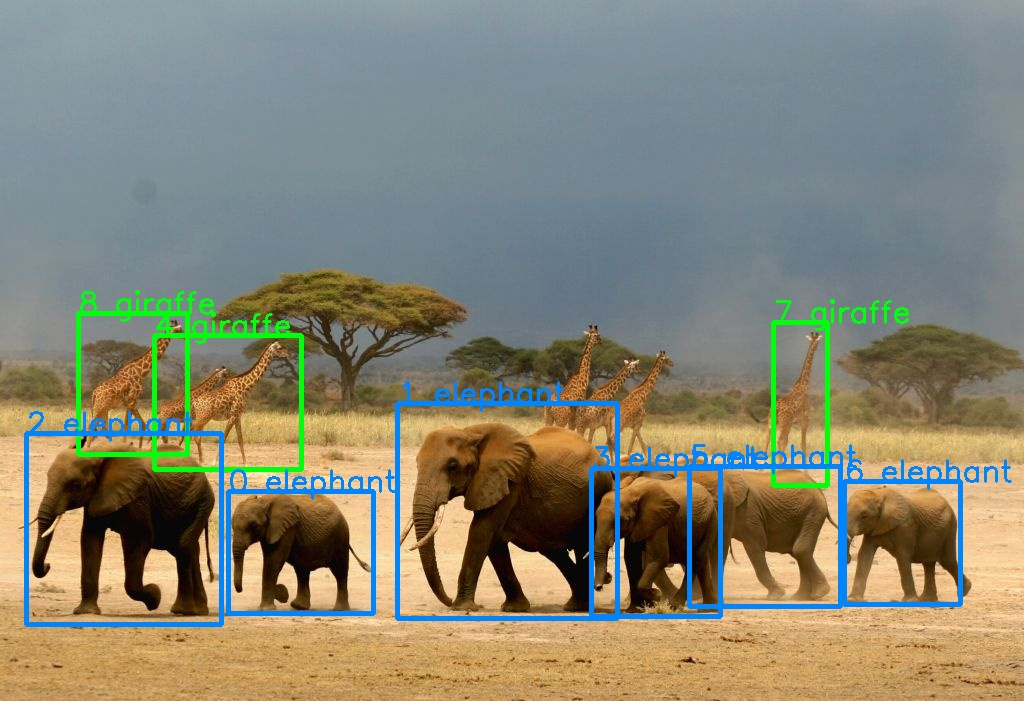

In [11]:
from IPython.display import Image
Image("images/safari_boxes.jpg")


# Interpret Results

*Do you notice how the 3 giraffes in the middle of the image are not highlighted?*
*Did you notice we only detected 2 giraphes and 5 elephants even though we should have detected 7 for both classes?*

First try this experiment, lets re-run the sequence above with a couple of different settings.  We will modify : 
- score_threshold from 05 -> 0.15
- iou_threshold from 0.5 -> 0.7

The score_threshold will reduce the required probabiliy for something to be considered detected.
The iou_threshold increase will reduce the pruning of overlapping boxes.  

To make this easier, a convenience function called infer image is used .  Essentially this encapsulates everything we did above into one inference function.


In [21]:
infer_image(input_image="./images/safari2.jpg",
            output_image="./images/safari_boxes.jpg",
            score_threshold=0.15,
            iou_threshold=0.7,
            max_boxes=15,
            audit_mode=True,
            tfdbg=False,
            mode="darknet")

set_image_shape : Setting self.image_shape to (701, 1024, 3)
load_and_build_graph : Loading DARKNET Model


/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


load_and_build_graph : Instantiating graph (yolo_head)
load_and_build_graph : Loading yolo eval.  Final part of yolo that perform non max suppression and scoring
load_and_build_graph : Max Boxes = 15, Object Probability Threshold (Pobj*ProbCls) = 0.15, IOU threshold = 0.7
yolo_filter_boxes : Filter threshold = 0.15
preprocess_image_cpu : Yolo model image size requirement = (608, 608)
preprocess_image_cpu : Raw  input image size             = 701 1024 3
get_rotation : Rotation set to : 0 degrees
get_rotation : Rotation set to : 0 degrees
Found 15 boxes for current batch 0
draw_boxes : 14 classIdx=20 label=elephant 0.16 xmin,ymin=(623, 505) xmax,ymax=(719, 613)
draw_boxes : 13 classIdx=23 label=giraffe 0.22 xmin,ymin=(178, 352) xmax,ymax=(285, 470)
draw_boxes : 12 classIdx=23 label=giraffe 0.23 xmin,ymin=(547, 332) xmax,ymax=(614, 441)
draw_boxes : 11 classIdx=20 label=elephant 0.24 xmin,ymin=(584, 480) xmax,ymax=(694, 599)
draw_boxes : 10 classIdx=20 label=elephant 0.25 xmin,ymin=(715, 

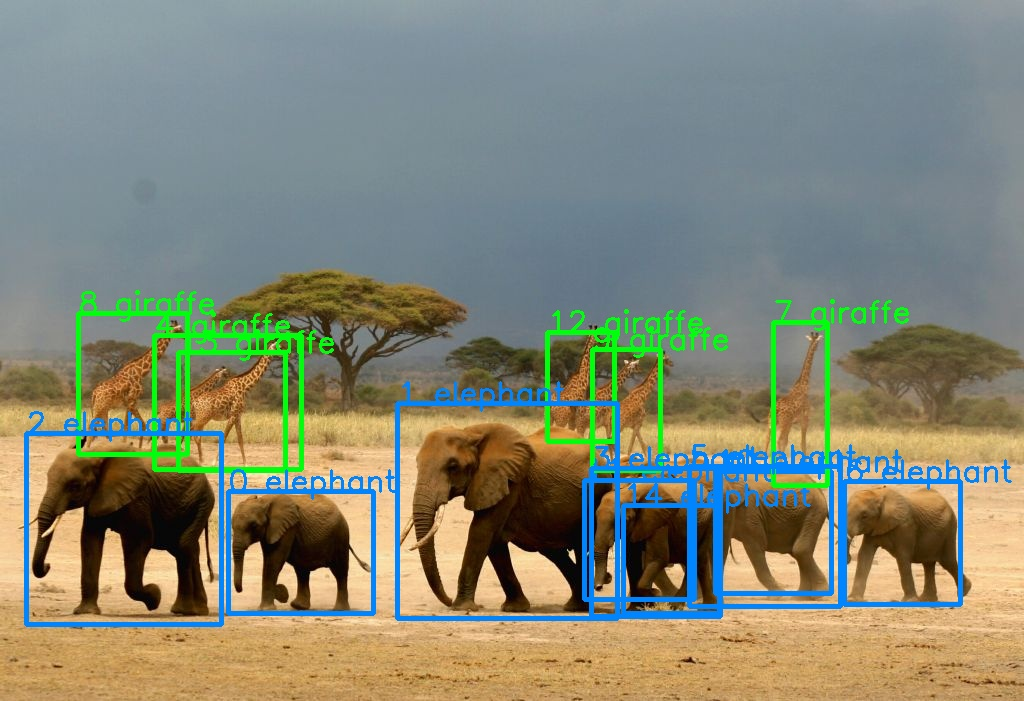

In [13]:
Image("images/safari_boxes.jpg")

# Explanation of new image results

When score threshold is changed from 0.5 to 0.15 we pick up the giraffes in the middle.  And the iou_threshold increase allows us to keep more boxes even though we have overlaps.  Still not a perfect result, but a lot better than before.  **Feel free to try a couple of different settings here to get a sense of how the knobs work.**

For images with a high concentration of objects, these knobs require some tuning to get the best results.  Also training with more images that represent this distribution of pictures would help quite a bit too.  Not bad for a general purpose model though.



Next, lets try this with a sample image downloaded from the web

# [Optional ]: Download image from the web, and perform inference

Use google and search for images of something below....

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

Once you find a jpg, copy the link using ** copy link address ** and then paste the link after the wget command below.

Then run the wget command below to save into the images directory (just leave the output file name as test.jpg)



In [ ]:
#### Change the code below ###
# this one was a fun image .. 
# https://cdn.shopify.com/s/files/1/2298/4179/products/20-5630_FruitBowlFilled.jpg?v=1507743561
# https://images.unsplash.com/photo-1534531419963-a19df4e34255?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=3cef0a0fed84d883cad96c8aa55b0229&auto=format&fit=crop&w=800&q=60
# https://bloximages.newyork1.vip.townnews.com/theadvocate.com/content/tncms/assets/v3/editorial/7/20/7202a220-226c-11e8-ae6d-2b0eacce3eca/5a57e4bc3a1b6.image.jpg?resize=1200%2C793

!wget 'type your url here' -O images/test.jpg

#### Dont change below this line ####
# Verify the image is now in the images directory
!ls images

# Verify file is an image ...
!file images/test.jpg

In [ ]:
#### Dont need to change this code ####
input_image ="images/test.jpg"
output_file = "./images/optional_test.jpg"

infer_image(input_image=input_image,
            output_image=output_file,
            score_threshold=0.15,
            iou_threshold=0.7,
            max_boxes=15,
            audit_mode=True,
            tfdbg=False,
            mode="darknet")

In [ ]:
Image(output_file)

# Label a video with bounding boxes

Here we make use of everything we have just done above, but now we will process a video which is jsut a series of images.  You can think of it like adding an outer loop to processing an image.

Here we use openCV to read portions of a video into a numpy array, and have a few settings to control the # of frames processed.  Also for time purposes, we skip a couple of frames just to make the processing go quicker.  Run the function below to see the end result

In [22]:
infer_video(input_video="./sampleVideos/ElephantStampede2.mov",
            audit_mode=False,
            output_dir="./output",
            mode="darknet",
            batch_size=8,
            frame_stride=10)


output_dir : Removing old output dir
set_image_shape : Setting self.image_shape to (720, 1280, 3)
load_and_build_graph : Loading DARKNET Model


/Users/dustinvanstee/.virtualenvs/cssc_env36_tf18/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


load_and_build_graph : Instantiating graph (yolo_head)
load_and_build_graph : Loading yolo eval.  Final part of yolo that perform non max suppression and scoring
load_and_build_graph : Max Boxes = 10, Object Probability Threshold (Pobj*ProbCls) = 0.5, IOU threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
yolo_filter_boxes : Filter threshold = 0.5
process_video : Total # frames in input movie = 1492
process_video : Batch Size = 8
process_video : Frame Stride = 10
process_video : Each loop will consume 88 frames 
process_video : Writing MOV video format for x86_64
process_video : Saving new movie here ./output/processed_video.mov
process_video : Total number of loops = 16 
process_video : -------------------------------------

process_video : --------------------------------------------------
process_video : loop count 5 : Frame shape = (8, 720, 1280, 3)
process_video : --------------------------------------------------
preprocess_image_cpu : Yolo model image size requirement = (608, 608)
preprocess_image_cpu : Raw  input image size             = 720 1280 3
get_rotation : Rotation set to : 0 degrees
get_rotation : Rotation set to : 0 degrees
Found 0 boxes for current batch 0
Found 0 boxes for current batch 1
Found 0 boxes for current batch 2
Found 1 boxes for current batch 3
Found 1 boxes for current batch 4
Found 0 boxes for current batch 5
Found 0 boxes for current batch 6
Found 1 boxes for current batch 7
process_video : Image 0 of 8
process_video : Image 1 of 8
process_video : Image 2 of 8
process_video : Image 3 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.64 xmin,ymin=(955, 276) xmax,ymax=(1034, 357)
process_video : Image 4 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.66 xmin,ymin=(918, 275) xm

process_video : --------------------------------------------------
process_video : loop count 10 : Frame shape = (8, 720, 1280, 3)
process_video : --------------------------------------------------
preprocess_image_cpu : Yolo model image size requirement = (608, 608)
preprocess_image_cpu : Raw  input image size             = 720 1280 3
get_rotation : Rotation set to : 0 degrees
get_rotation : Rotation set to : 0 degrees
Found 3 boxes for current batch 0
Found 3 boxes for current batch 1
Found 3 boxes for current batch 2
Found 2 boxes for current batch 3
Found 2 boxes for current batch 4
Found 2 boxes for current batch 5
Found 1 boxes for current batch 6
Found 1 boxes for current batch 7
process_video : Image 0 of 8
draw_boxes : 2 classIdx=20 label=elephant 0.72 xmin,ymin=(14, 156) xmax,ymax=(144, 498)
draw_boxes : 1 classIdx=20 label=elephant 0.85 xmin,ymin=(814, 270) xmax,ymax=(919, 388)
draw_boxes : 0 classIdx=20 label=elephant 0.87 xmin,ymin=(447, 243) xmax,ymax=(687, 417)
process_v

Found 1 boxes for current batch 0
Found 1 boxes for current batch 1
Found 1 boxes for current batch 2
Found 1 boxes for current batch 3
Found 1 boxes for current batch 4
Found 2 boxes for current batch 5
Found 1 boxes for current batch 6
Found 1 boxes for current batch 7
process_video : Image 0 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.84 xmin,ymin=(406, 91) xmax,ymax=(1046, 481)
process_video : Image 1 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.88 xmin,ymin=(386, 81) xmax,ymax=(1011, 569)
process_video : Image 2 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.87 xmin,ymin=(318, 92) xmax,ymax=(939, 543)
process_video : Image 3 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.92 xmin,ymin=(300, 97) xmax,ymax=(889, 535)
process_video : Image 4 of 8
draw_boxes : 0 classIdx=20 label=elephant 0.91 xmin,ymin=(280, 94) xmax,ymax=(889, 538)
process_video : Image 5 of 8
draw_boxes : 1 classIdx=14 label=bird 0.63 xmin,ymin=(862, 477) xmax,ymax=(991, 677)
draw_boxes : 0 classIdx=20 

In [ ]:
# Workaround to convert avi file to mov... Need this to display movie in notebook for now
!ffmpeg  -y -loglevel warning -i output/processed_video.avi  ./output/processed_video.mov
!ls -l output # should see ./output/processed_video.mov

### Play the labelled video

<center>
<video width="1200" height="600" src="./output/processed_video.mov" type="video/mov" controls>
</video>
</center>

### Summary

<font color='blue'>
**What you should remember**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 

<font color='black'>

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 
- Coursera.com / deeplearning.ai - (YOLO lectures and Lab)